In [1]:
import torch
from torch import Tensor
import numpy as np
import einops
from typing import Optional, Iterable

from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def window_partition(x: Optional[Tensor], window_size: int):
    if len(x.shape) == 3:
        return x
    # do not flatten windows for visualization
    return einops.rearrange(x, 'b (h wh) (w ww) c -> (b h w) wh ww c', wh=window_size, ww=window_size)

def window_partition_reversed(x: Optional[Tensor], x_size: Iterable[int], window_size: int):
    height, width = x_size
    h, w = height // window_size, width // window_size
    return einops.rearrange(x, '(b h w) wh ww c -> b (h wh) (w ww) c', h=h, w=w)

In [3]:
x = data.astronaut()
x = torch.from_numpy(x[None, ...])
x.shape

torch.Size([1, 512, 512, 3])

In [4]:
window_size = 64
x_windows = window_partition(x, window_size)
x_windows.shape

torch.Size([64, 64, 64, 3])

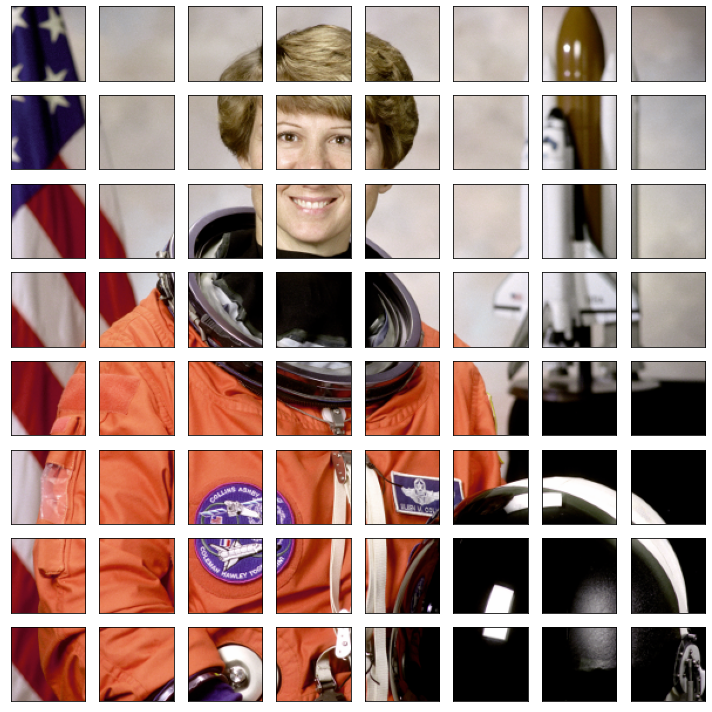

In [5]:
fig, axes = plt.subplots(ncols=x.shape[1] // window_size, nrows=x.shape[2] // window_size, figsize=(10, 10))
for xw, ax in zip(x_windows, axes.flat):
    ax.imshow(xw)
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()
plt.show()

Test equivalence of rearrange vs `torch.PixelUnshuffle`

In [6]:
stride = 2
downscaled = einops.rearrange(x_windows, 'b (wh sh) (ww sw) c -> b (sh sw) wh ww c', sh=stride, sw=stride)
assert downscaled.shape == (64, 4, 32, 32, 3)
assert torch.all(x_windows[:, ::2, ::2] == downscaled[:, 0])
assert torch.all(x_windows[:, ::2, 1::2] == downscaled[:, 1])
assert torch.all(x_windows[:, 1::2, ::2] == downscaled[:, 2])
assert torch.all(x_windows[:, 1::2, 1::2] == downscaled[:, 3])

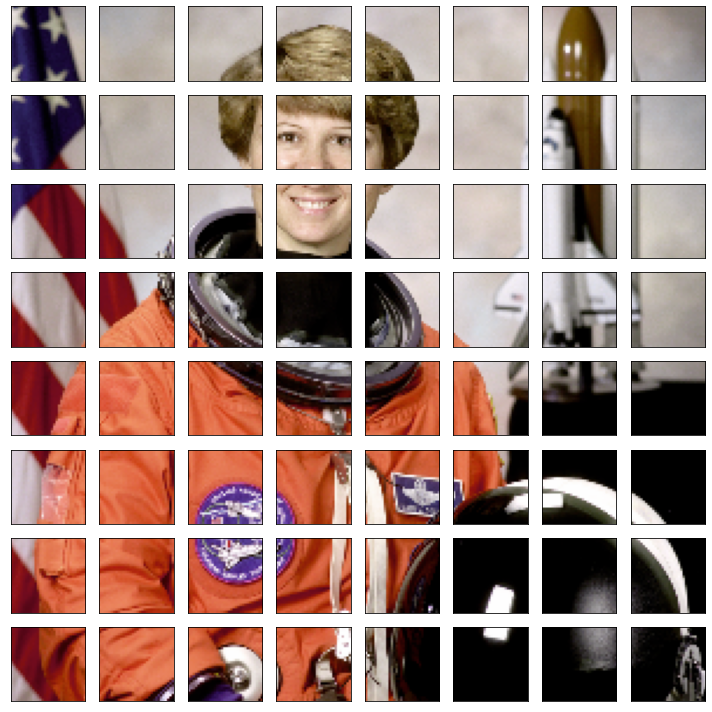

In [7]:
fig, axes = plt.subplots(ncols=x.shape[1] // window_size, nrows=x.shape[2] // window_size, figsize=(10, 10))
for xw, ax in zip(downscaled[:, 0], axes.flat):
    ax.imshow(xw)
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()
plt.show()

In [8]:
def strided_window_partition(x: Optional[Tensor], window_size: int, stride: int = 1):
    if len(x.shape) == 3:
        return x
    # do not flatten windows and strides for visualization
    return einops.rearrange(x, 'b (h wh sh) (w ww sw) c -> (b h w) (sh sw) wh ww c', 
                            wh=window_size, ww=window_size, sh=stride, sw=stride)

def strided_window_partition_reversed(x: Optional[Tensor], x_size: Iterable[int], window_size: int, stride: int = 1):
    height, width = x_size
    h, w = height // window_size, width // window_size
    return einops.rearrange(x, '(b h w) (sh sw) wh ww c -> b (h wh sh) (w ww sw) c', h=h, w=w, sh=stride, sw=stride)

In [9]:
window_size = 32
stride = 4
x_windows = strided_window_partition(x, window_size, stride)
x_windows.shape

torch.Size([16, 16, 32, 32, 3])

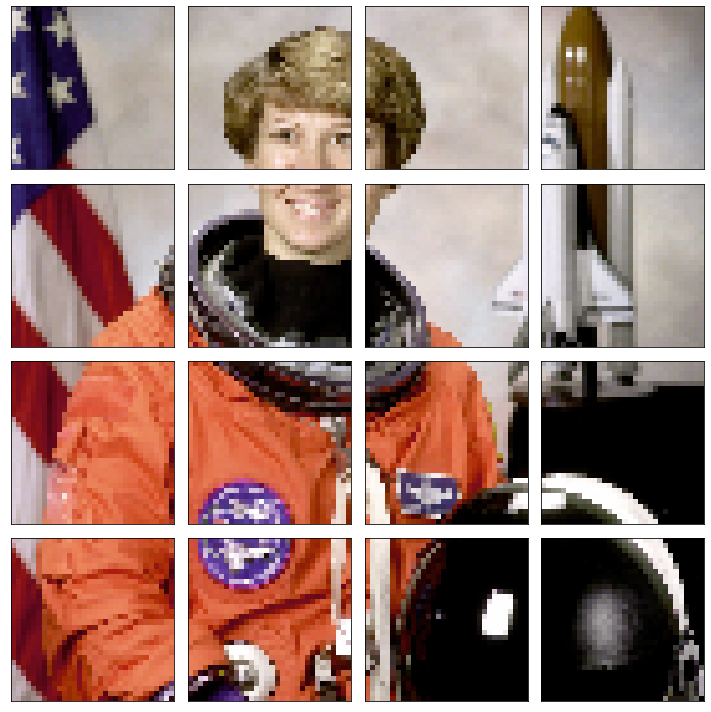

In [10]:
fig, axes = plt.subplots(ncols=x.shape[1] // (window_size * stride), 
                         nrows=x.shape[2] // (window_size * stride), 
                         figsize=(10, 10))
for xw, ax in zip(x_windows[:, 0], axes.flat):
    ax.imshow(xw)
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()
plt.show()

In [11]:
x_size = (32, 32)
window_size = 8
shift_size = window_size // 2

In [13]:
import itertools
from typing import Tuple

def calculate_attention_groups(x_size: Tuple[int, int], window_size: int, shift_size: int, dilation: int = 1):
    attn_mask = torch.zeros((1, *x_size, 1))
    if shift_size != 0:
        slices = (slice(0, -window_size * dilation),
                  slice(-window_size * dilation, -shift_size * dilation),
                  slice(-shift_size * dilation, None))
        cnt = 0        
        for h, w in itertools.product(slices, slices):
            attn_mask[:, h, w, :] = cnt
            cnt += 1
    return attn_mask

In [14]:
attn_mask = calculate_attention_groups(x_size, window_size, shift_size)
attn_mask.shape

torch.Size([1, 32, 32, 1])

In [15]:
attn_mask_wp = window_partition(attn_mask, window_size)
attn_mask_wp.shape

torch.Size([16, 8, 8, 1])

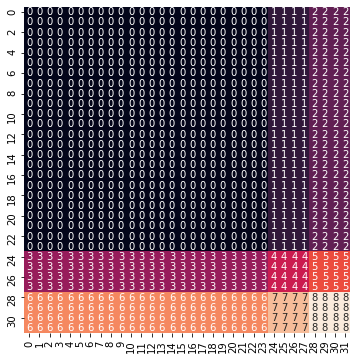

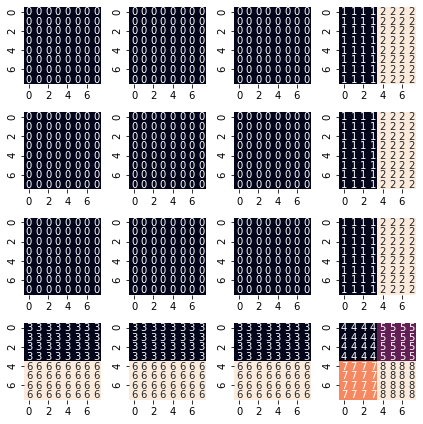

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(attn_mask[0, ..., 0], cbar=False, square=True, annot=True, ax=ax)
plt.show()

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
for ax, w in zip(axes.flat, attn_mask_wp):
    sns.heatmap(w[..., 0], cbar=False, square=True, annot=True, ax=ax)
plt.tight_layout()
plt.show()

In [17]:
attn_mask_wp = strided_window_partition(attn_mask, window_size, stride=2)
attn_mask_wp.shape

torch.Size([4, 4, 8, 8, 1])

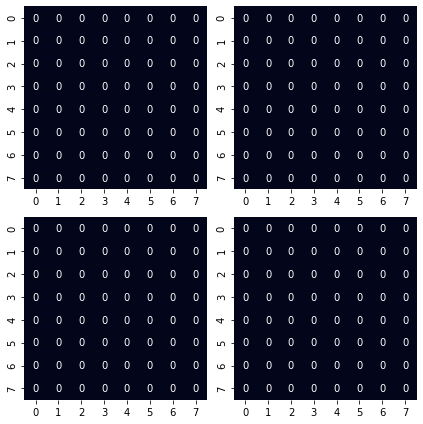

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
for ax, w in zip(axes.flat, attn_mask_wp[0]):
    sns.heatmap(w[..., 0], cbar=False, square=True, annot=True, ax=ax)
plt.tight_layout()
plt.show()

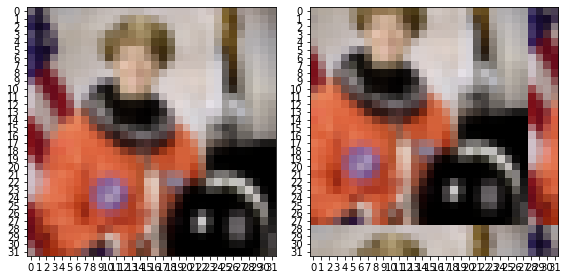

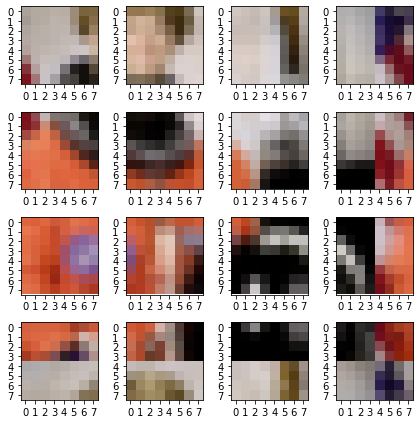

In [19]:
x = data.astronaut()
x = resize(x, x_size)
x_shifted = np.roll(x, shift=(-shift_size, -shift_size), axis=(0, 1))

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].imshow(x)
ax[1].imshow(x_shifted)
plt.setp(ax, xticks=range(x_size[0]), yticks=range(x_size[1]))
plt.tight_layout()
plt.show()


x_shifted_wp = window_partition(x_shifted[None, ...], window_size)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
for ax, w in zip(axes.flat, x_shifted_wp):
    ax.imshow(w)
plt.setp(axes, xticks=range(window_size), yticks=range(window_size))
plt.tight_layout()
plt.show()

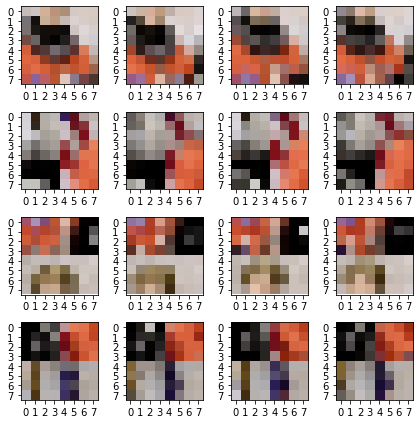

In [20]:
stride = 2
x_shifted = np.roll(x, shift=(-shift_size * stride, -shift_size * stride), axis=(0, 1))
x_shifted_wp = strided_window_partition(x_shifted[None, ...], window_size, stride=stride)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
for ax, w in zip(axes.flat, x_shifted_wp.reshape(16, 8, 8, 3)):
    ax.imshow(w)
plt.setp(axes, xticks=range(window_size), yticks=range(window_size))
plt.tight_layout()
plt.show()

In [ ]:
class BlindSpotBlock(nn.Module):

    def __init__(
        self,
        embed_dim: int = 96,
        window_size: int = 8,
        shift_size: Tuple[int] = (0, 0),
        num_heads: int = 6,
        stride: int = 1,
        input_size: Tuple[int] = (128, 128),
        attn_drop: float = 0.05,
        proj_drop: float = 0.05,
        mode: SwinIAMode = SwinIAMode.DILATED
    ):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
        self.mlp = MLP(embed_dim, embed_dim, n_layers=2)
        self.mode = mode
        self.attn = DiagWinAttention(
            embed_dim,
            to_2tuple(window_size), mode,
            num_heads, attn_drop, proj_drop
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.window_size = window_size
        self.shift_size = np.array(shift_size) if mode == SwinIAMode.SHUFFLED else np.array(shift_size) * stride
        self.stride = stride
        self.embed_dim = embed_dim
        self.input_size = input_size
        self.attn_mask = self.calculate_mask(input_size)
        self.shortcut = MLP(embed_dim * 2, embed_dim)

    def shift_image(self, x: Optional[Tensor]):
        if x.shape[-1] != self.embed_dim or np.all(self.shift_size == 0):
            return x
        else:
            coef = self.stride if self.mode == SwinIAMode.SHUFFLED else 1
            return torch.roll(x, shifts=tuple(-self.shift_size * coef), dims=(1, 2))

    def shift_image_reversed(self, x: Optional[Tensor]):
        if np.all(self.shift_size == 0):
            return x
        coef = self.stride if self.mode == SwinIAMode.SHUFFLED else 1
        return torch.roll(x, shifts=tuple(self.shift_size * coef), dims=(1, 2))

    def window_partition(self, x: Optional[Tensor]):
        if x.shape[-1] != self.embed_dim and x.shape[-1] != 1:
            return x
        return einops.rearrange(x, 'b (h wh) (w ww) c -> (b h w) (wh ww) c', wh=self.window_size, ww=self.window_size)

    def window_partition_reversed(self, x: Optional[Tensor], x_size: Iterable[int]):
        height, width = x_size
        h, w = height // self.window_size, width // self.window_size
        return einops.rearrange(x, '(b h w) (wh ww) c -> b (h wh) (w ww) c', h=h, w=w)

    def strided_window_partition(self, x: Optional[Tensor]):
        if x.shape[-1] != self.embed_dim:
            return x
        expression = 'b (h wh sh) (w ww sw) c -> (b h w) (wh ww) (sh sw) c' if self.mode == SwinIAMode.SHUFFLED else \
                     'b (h wh sh) (w ww sw) c -> (b h w sh sw) (wh ww) c'
        return einops.rearrange(x, expression, wh=self.window_size, ww=self.window_size, sh=self.stride, sw=self.stride)

    def strided_window_partition_reversed(self, x: Optional[Tensor], x_size: Iterable[int]):
        height, width = x_size
        h, w = height // self.window_size // self.stride, width // self.window_size // self.stride
        expression = '(b h w) (wh ww) (sh sw) c -> b (h wh sh) (w ww sw) c' if self.mode == SwinIAMode.SHUFFLED else \
                     '(b h w sh sw) (wh ww) c -> b (h wh sh) (w ww sw) c'
        return einops.rearrange(x, expression, h=h, w=w, sh=self.stride, sw=self.stride, wh=self.window_size)

    def calculate_mask(self, x_size):
        if self.mode == SwinIAMode.SHUFFLED:
            x_size = [s // self.stride for s in x_size]
        attn_mask = torch.zeros((1, *x_size, 1))
        if np.any(self.shift_size != 0):
            h_slices = (slice(0, -self.shift_size[0]),
                        slice(-self.shift_size[0], None))
            w_slices = (slice(0, -self.shift_size[1]),
                        slice(-self.shift_size[1], None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    attn_mask[:, h, w, :] = cnt
                    cnt += 1
        attn_mask = self.window_partition(attn_mask) if self.mode == SwinIAMode.SHUFFLED else \
                    self.strided_window_partition(attn_mask)
        attn_mask = einops.rearrange(attn_mask, "nw np 1 -> nw 1 np") - attn_mask
        torch.diagonal(attn_mask, dim1=-2, dim2=-1).fill_(1)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-10 ** 9))
        return attn_mask

    def forward(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
    ):
        image_size = key.shape[1:-1]
        if query.shape[-1] == self.embed_dim:
            query = self.norm1(query)
        query, key, value = map(self.shift_image, (query, key, value))
        query, key, value = map(self.strided_window_partition, (query, key, value))
        mask = self.attn_mask if image_size == self.input_size else self.calculate_mask(image_size).to(key.device)
        query, key, value = self.attn(query, key, value, mask=mask)
        query, key, value = map(self.strided_window_partition_reversed, (query, key, value), [image_size] * 3)
        query, key, value = map(self.shift_image_reversed, (query, key, value))
        query = connect_shortcut(self.shortcut, query, self.mlp(self.norm2(query)))
        return query, key, value


Split image

In [28]:
x_size = (32, 32)
window_size = 8
dilation = 2
shift_size = (window_size // 2, window_size // 2)

x = data.astronaut()
x = resize(x, x_size)[None, ...]

x_windowed = einops.rearrange(x, 'b (h wh dh) (w ww dw) c -> (b h w) (wh ww) (dh dw) c', 
                              wh=window_size, ww=window_size, dh=dilation, dw=dilation)

x.shape, x_windowed.shape

((1, 32, 32, 3), (4, 64, 4, 3))

Calculate attention mask

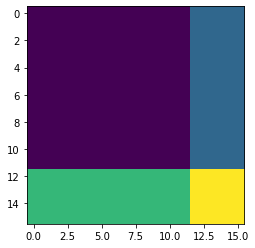

torch.Size([4, 64, 64])

In [45]:
x_size_mask = [s // dilation for s in x_size]
attn_mask = torch.zeros((1, *x_size_mask, 1))

if np.any(shift_size != 0):
    slices = [(slice(0, -s), slice(-s, None)) for s in shift_size]
    cnt = 0
    for h, w in itertools.product(*slices):
        attn_mask[:, h, w, :] = cnt
        cnt += 1

plt.imshow(attn_mask[0])
plt.show()
            
attn_mask = einops.rearrange(attn_mask, 'b (h wh) (w ww) c -> (b h w) (wh ww) c', wh=window_size, ww=window_size)
attn_mask = einops.rearrange(attn_mask, "nw np 1 -> nw 1 np") - attn_mask
torch.diagonal(attn_mask, dim1=-2, dim2=-1).fill_(1)
attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-10 ** 9))

attn_mask.shape

In [41]:
attn_mask[:, ::2, ::2].shape

torch.Size([4, 32, 32])

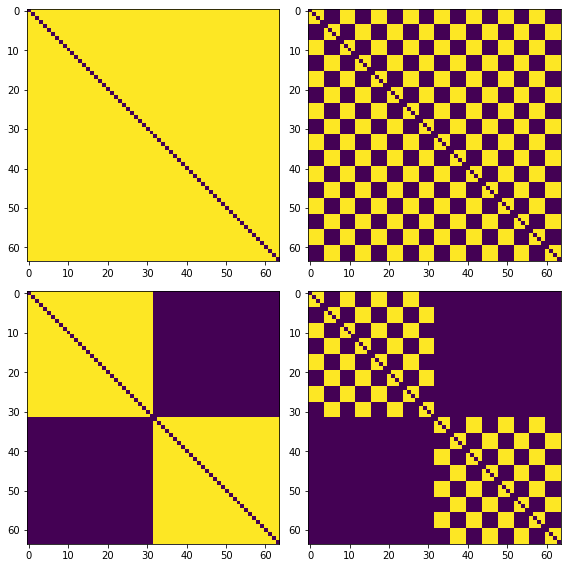

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for ax, w in zip(axes.flat, attn_mask):
    ax.imshow(w)

plt.tight_layout()
plt.show()